# Introduction
This notebook uses survey data collected from Dec 2022 to Mar 2023 on smartphone wellbeing feature awareness and usage. The CSV file used in this analysis has been deidentified and manipulated in Excel before being brough into Jupyter Notebooks.

# Data Setup

In [1]:
# import packages for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# import data
df = pd.read_csv('wellbeing_survey_responses.csv')
df.dropna(subset=['age'],inplace=True) #there is one row with all blanks including the age

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353 entries, 0 to 353
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  353 non-null    int64  
 1   response_timestamp                  353 non-null    object 
 2   age                                 353 non-null    object 
 3   feature_learn_method                352 non-null    object 
 4   autonomy_avgscore                   345 non-null    float64
 5   competence_avgscore                 349 non-null    float64
 6   relatedness_avgscore                351 non-null    float64
 7   pressured_to_use_more               348 non-null    float64
 8   spend_more_time_than_should         351 non-null    float64
 9   makes_me_do_unwanted_things         350 non-null    float64
 10  life_intrusive                      352 non-null    float64
 11  more_ability_insecurity             351 non-n

## Data Encoding

In [3]:

# convert timestamp column from object to datetime data type
df['response_timestamp'] = pd.to_datetime(df['response_timestamp'])

# encode the ordinal age column to labels
age_ordinal_values = { 'Prefer not to answer': -1, '18 to 24 years': 1, '25 to 34 years': 2
                      , '35 to 44 years': 3, '45 to 54 years': 4, '55 to 64 years': 5,
                     '65+ years': 6}

df['age_encoded'] = df['age'].map(age_ordinal_values)

# encode the categorical feature learning column to one-hot encoding
flm_one_hot_df = pd.get_dummies(data=df['feature_learn_method'], prefix='flm', dummy_na=True)

df = pd.concat([df, flm_one_hot_df], axis=1)

# encode the categorical phone type column to iPhone flag, question was required in survey so data cannot be blank
def phone_type_mapping_func(ptype : str):
    if ptype == 'Prefer not to answer':
        return -1
    elif ptype == 'Apple iPhone':
        return 1
    else:
        return 0
    
df['iphone_flag'] = df['phone_type'].apply(phone_type_mapping_func)

# create a Categorical type column out of the age column which orders the age categories
age_order_list = ['18 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years'
, '55 to 64 years', '65+ years', 'Prefer not to answer']

df['age_categorical'] = pd.Categorical(df['age'], categories=age_order_list, ordered=True)

# coalesce the awareness and usage columns to one column for analysis
# source: https://www.statology.org/pandas-coalesce/
df['all_phone_feature_aware'] = df[['iphone_aware', 'samsung_aware', 'pixel_aware', 'other_aware']].bfill(axis=1).iloc[:, 0]
df['all_phone_feature_usage'] = df[['iphone_usage', 'samsung_usage', 'pixel_usage', 'other_usage']].bfill(axis=1).iloc[:, 0]

# encode the feature learn method column to a passive versus active flag column.
def active_learn_method_mapping_func(flm : str):
    if flm == 'OrganicUsage' or flm == 'AnotherPerson':
        return 0
    else:
        return 1
    
df['active_learn_method_flag'] = df['feature_learn_method'].apply(active_learn_method_mapping_func)

## Calculate ACTA Score

In [4]:

# Calculate the autonomous regulation score by getting the average score for questions that are
# intrinsic and identified motivated
intrinsic_identified_columns_list = ['expected_interesting_intrinsic', 'belief_life_improvement_identified'
                                     ,'help_do_important_identified', 'expect_enjoyable_intrinsic'
                                     , 'be_of_value_life_identified', 'fun_to_use_intrinsic']


df['autonomous_regulation_score'] = df[intrinsic_identified_columns_list].mean(axis=1)

In [5]:
# Calculate the controlled regulation score by getting the average score for questions that are
# external and introjected motivated
external_introjected_columns_list = ['others_want_me_use_external', 'others_know_usage_introjected'
                                     ,'feel_bad_not_trying_introjected', 'required_usage_external'
                                     , 'pressure_usage_external', 'look_good_others_introjected']


df['controlled_regulation_score'] = df[external_introjected_columns_list].mean(axis=1)

In [6]:
# Calculate relative autonomy index (RAI) by subtracting the average for Controlled Regulation
# from the average for Autonomous Regulation
df['relative_autonomy_index'] = df['autonomous_regulation_score'] - df['controlled_regulation_score']

In [37]:
df.columns

Index(['ID', 'response_timestamp', 'age', 'feature_learn_method',
       'autonomy_avgscore', 'competence_avgscore', 'relatedness_avgscore',
       'pressured_to_use_more', 'spend_more_time_than_should',
       'makes_me_do_unwanted_things', 'life_intrusive',
       'more_ability_insecurity', 'less_capable', 'lowered_confidence',
       'belonging_to_community', 'close_connect_important_persons',
       'close_to_some', 'phone_type', 'awareness_flag', 'awareness_count',
       'usage_flag', 'usage_count', 'others_want_me_use_external',
       'expected_interesting_intrinsic', 'belief_life_improvement_identified',
       'help_do_important_identified', 'others_know_usage_introjected',
       'feel_bad_not_trying_introjected', 'expect_enjoyable_intrinsic',
       'required_usage_external', 'be_of_value_life_identified',
       'fun_to_use_intrinsic', 'pressure_usage_external',
       'look_good_others_introjected', 'iphone_aware', 'iphone_usage',
       'pixel_aware', 'pixel_usage', 'oth

# Descriptive Statistics

In [7]:
# Helper function to print distribution count and percentages of total for columns
def print_column_value_counts(column):
    print(df[column].value_counts(), '\n')
    print(df[column].value_counts(normalize=True))

In [8]:
# Helper function to create a basic seaborn displot historgram for a column
def create_displot_from_column(column_x_value):
    displot = sns.displot(data=df, x=column_x_value)
    displot.set_xticklabels(rotation=45, ha='right')
    return displot

## Age Only

### How many surveyed participants in each age group?

In [46]:
print_column_value_counts(['age'])

age                 
25 to 34 years          117
18 to 24 years           74
35 to 44 years           49
65+ years                45
45 to 54 years           33
55 to 64 years           31
Prefer not to answer      4
dtype: int64 

age                 
25 to 34 years          0.331445
18 to 24 years          0.209632
35 to 44 years          0.138810
65+ years               0.127479
45 to 54 years          0.093484
55 to 64 years          0.087819
Prefer not to answer    0.011331
dtype: float64


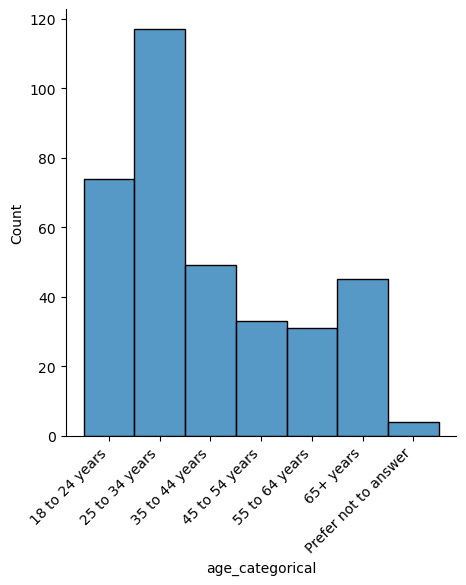

In [16]:
create_displot_from_column('age_categorical')
#age_displot = sns.displot(data=df, x='age_categorical')
#age_displot.set_xticklabels(rotation=45, ha='right')

## Feature Learn Method Only

### How do surveyed participants typically learn about smartphone features?

In [69]:
print_column_value_counts(['feature_learn_method'])

OrganicUsage         154
AnotherPerson        114
Proactive             43
SearchAfterUpdate     39
CompanyEmail           2
Name: feature_learn_method, dtype: int64 

OrganicUsage         0.437500
AnotherPerson        0.323864
Proactive            0.122159
SearchAfterUpdate    0.110795
CompanyEmail         0.005682
Name: feature_learn_method, dtype: float64


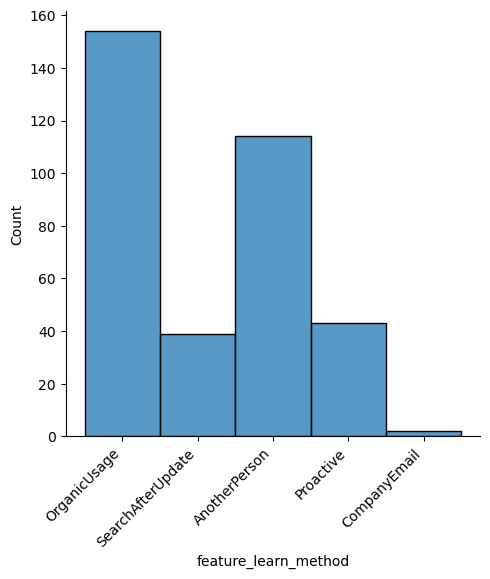

In [17]:
create_displot_from_column('feature_learn_method')

## Phone Type Only

### What types of smartphones were surveyed?

In [11]:
print_column_value_counts(['phone_type'])

phone_type          
Apple iPhone            247
Samsung                  62
Google Pixel             19
Motorola                  7
OnePlus                   7
Xiaomi                    4
Huawei                    2
Asus                      1
LG Nexus                  1
Prefer not to answer      1
Sony                      1
Xperia                    1
dtype: int64 

phone_type          
Apple iPhone            0.699717
Samsung                 0.175637
Google Pixel            0.053824
Motorola                0.019830
OnePlus                 0.019830
Xiaomi                  0.011331
Huawei                  0.005666
Asus                    0.002833
LG Nexus                0.002833
Prefer not to answer    0.002833
Sony                    0.002833
Xperia                  0.002833
dtype: float64


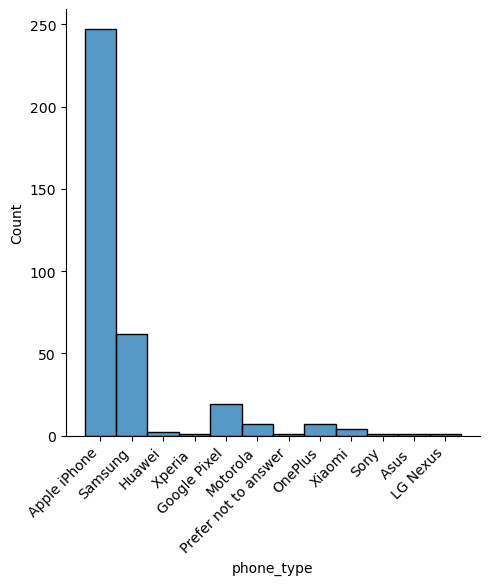

In [18]:
create_displot_from_column('phone_type')

## Awareness/Usage

### How many people were aware of smartphone wellbeing feature?

In [43]:
df['awareness_flag'].sum()

304

In [21]:
awareness_total = df['awareness_flag'].sum()
awareness_percentage = awareness_total / df['awareness_flag'].count()
print('Total number of people aware of wellbeing features =', awareness_total)
print('Percentage of people aware of wellbeing features =', awareness_percentage)

Total number of people aware of wellbeing features =  304
Percentage of people aware of wellbeing features =  86.11898016997166


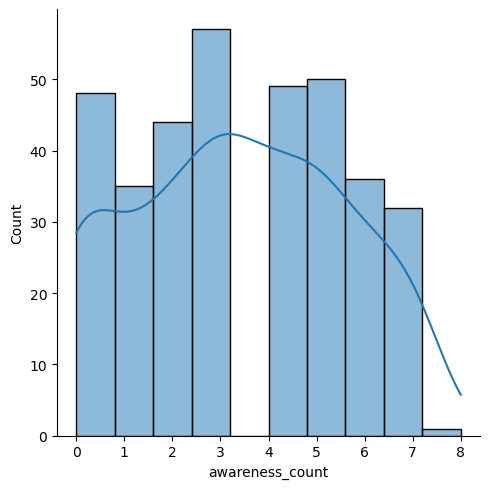

In [35]:
sns.displot(data=df, x='awareness_count', kde=True)

### What is the average, median, and mode for smarphone wellbeing feature awareness count?

In [32]:
print_column_value_counts(['awareness_count'])

awareness_count
3.0                57
5.0                50
4.0                49
0.0                48
2.0                44
6.0                36
1.0                35
7.0                32
8.0                 1
dtype: int64 

awareness_count
3.0                0.161932
5.0                0.142045
4.0                0.139205
0.0                0.136364
2.0                0.125000
6.0                0.102273
1.0                0.099432
7.0                0.090909
8.0                0.002841
dtype: float64


In [40]:
print('Awareness mean =', df['awareness_count'].mean())
print('Awareness median =', df['awareness_count'].median())
print('Awareness mode =', df['awareness_count'].mode()[0])

Awareness mean = 3.375
Awareness median = 3.0
Awareness mode = 3.0


See Google Form for images of how many of each feature was checked

### How many people use smartphone wellbeing features?

In [46]:
print('Number of people aware of at least one wellbeing feature =', df['usage_flag'].sum())


Number of people aware of at least one wellbeing feature = 251


### What is the average, median, and mode for smartphone wellbeing feature usage count?

In [47]:
usage_total = df['usage_flag'].sum()
usage_percentage = usage_total / df['usage_flag'].count()
print('Total number of people who use at least one wellbeing feature =', usage_total)
print('Percentage of people who use at least one wellbeing feature =', usage_percentage)

Total number of people who use at least one wellbeing feature = 251
Percentage of people who use at least one wellbeing feature = 0.7110481586402266


In [11]:
print('Usage mean =', df['usage_count'].mean())
print('Usage median =', df['usage_count'].median())
print('Usage mode =', df['usage_count'].mode()[0])

Usage mean = 1.4176136363636365
Usage median = 1.0
Usage mode = 1.0


In [12]:
print_column_value_counts(['usage_count'])

usage_count
1.0            116
0.0            101
2.0             67
3.0             41
4.0             13
5.0             10
6.0              4
dtype: int64 

usage_count
1.0            0.329545
0.0            0.286932
2.0            0.190341
3.0            0.116477
4.0            0.036932
5.0            0.028409
6.0            0.011364
dtype: float64


## Combinations

### Age vs Feature Learn Method

In [66]:
df.groupby('age_categorical')['feature_learn_method'].value_counts(normalize=True)

age_categorical       feature_learn_method
18 to 24 years        OrganicUsage            0.527027
                      AnotherPerson           0.283784
                      Proactive               0.094595
                      SearchAfterUpdate       0.081081
                      CompanyEmail            0.013514
25 to 34 years        OrganicUsage            0.470085
                      AnotherPerson           0.273504
                      SearchAfterUpdate       0.153846
                      Proactive               0.094017
                      CompanyEmail            0.008547
35 to 44 years        OrganicUsage            0.387755
                      AnotherPerson           0.285714
                      Proactive               0.183673
                      SearchAfterUpdate       0.142857
45 to 54 years        OrganicUsage            0.437500
                      AnotherPerson           0.312500
                      Proactive               0.125000
                      

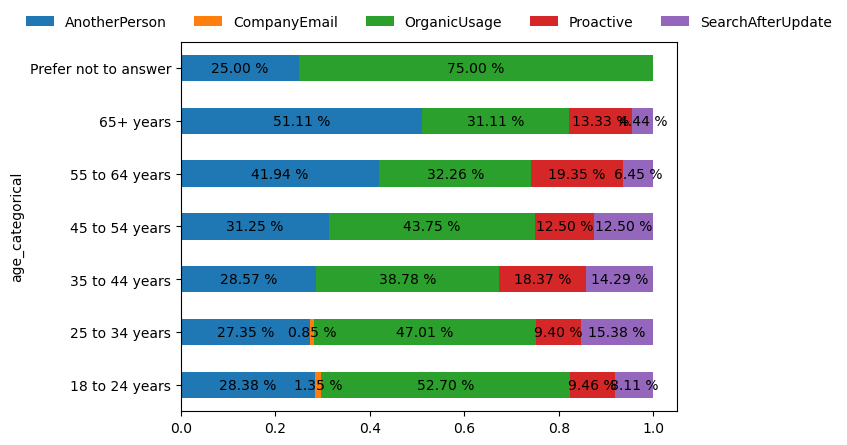

In [23]:
# Source: https://stackoverflow.com/questions/64754905/100-stacked-bar-chart-python-seaborn-matplotlib
df_grouped = df.groupby('age_categorical')['feature_learn_method'].value_counts(normalize=True).unstack('feature_learn_method')
df_grouped.plot.barh(stacked=True)

plt.legend(
    bbox_to_anchor=(0.5, 1.02),
    loc="lower center",
    borderaxespad=0,
    frameon=False,
    ncol=5,
)

for age_index, flm in df_grouped.reset_index(drop=True).iterrows():
    cumulative = 0
    for element in flm:
        if np.isnan(element):
            element = 0
        else:
            plt.text(
                cumulative + element / 2,
                age_index,
                f"{element * 100:.1f} %",
                va="center",
                ha="center",
            )
        cumulative += element

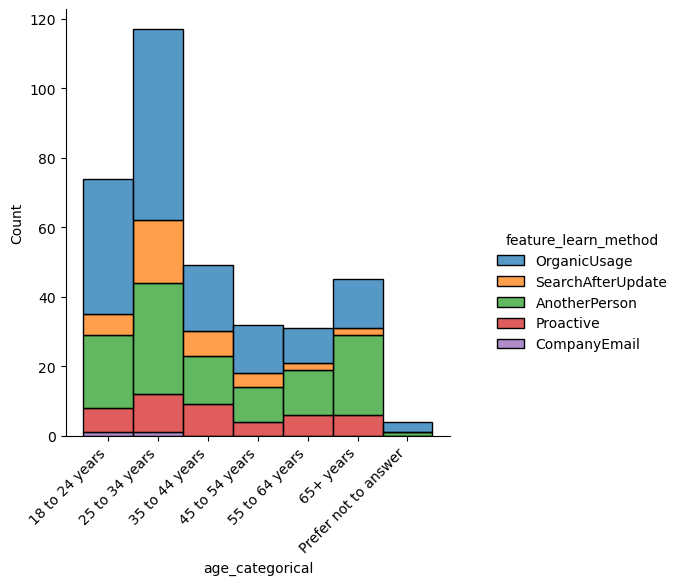

In [40]:
# stacked 100% bar chart
# chi-square test
# maybe combining the the FLM to passive vs active
chart = sns.displot(data=df, x='age_categorical', hue='feature_learn_method', multiple='stack')
chart.set_xticklabels(rotation=45, ha='right')
plt.show()

### Age vs Smartphone Type

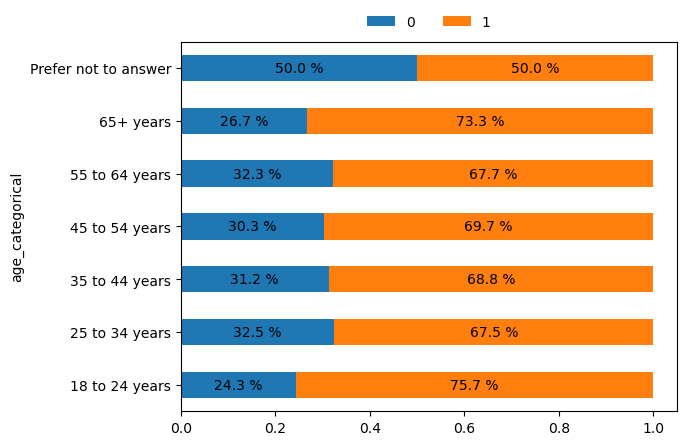

In [37]:
# Source: https://stackoverflow.com/questions/64754905/100-stacked-bar-chart-python-seaborn-matplotlib
df_grouped = df[df['iphone_flag'] >= 0].groupby('age_categorical')['iphone_flag'].value_counts(normalize=True).unstack('iphone_flag')
df_grouped.plot.barh(stacked=True)

plt.legend(
    bbox_to_anchor=(0.5, 1.02),
    loc="lower center",
    borderaxespad=0,
    frameon=False,
    ncol=2,
)

for age_index, flag in df_grouped.reset_index(drop=True).iterrows():
    cumulative = 0
    for element in flag:
        if np.isnan(element) or element < 0:
            element = 0
        else:
            plt.text(
                cumulative + element / 2,
                age_index,
                f"{element * 100:.1f} %",
                va="center",
                ha="center",
            )
        cumulative += element

### Smartphone Type vs Feature Learn Method

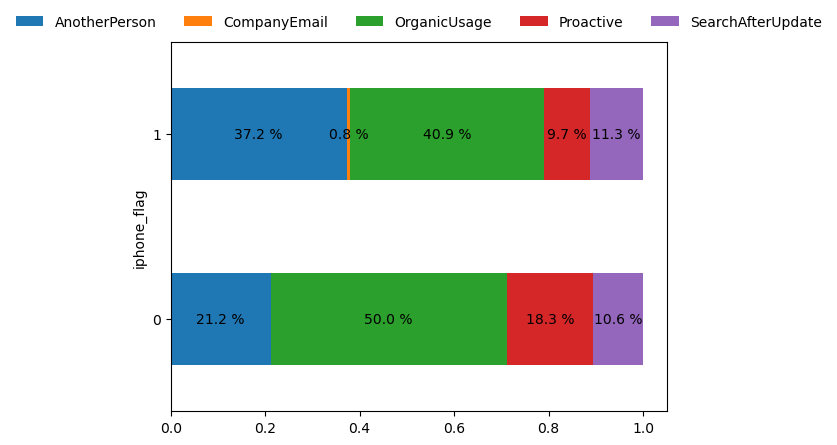

In [13]:
# Source: https://stackoverflow.com/questions/64754905/100-stacked-bar-chart-python-seaborn-matplotlib
df_grouped = df[df['iphone_flag'] >= 0].groupby('iphone_flag')['feature_learn_method'].value_counts(normalize=True).unstack('feature_learn_method')
df_grouped.plot.barh(stacked=True)

plt.legend(
    bbox_to_anchor=(0.5, 1.02),
    loc="lower center",
    borderaxespad=0,
    frameon=False,
    ncol=5,
)

for iphone_flag, flm in df_grouped.reset_index(drop=True).iterrows():
    cumulative = 0
    for element in flm:
        if np.isnan(element) or element < 0:
            element = 0
        else:
            plt.text(
                cumulative + element / 2,
                iphone_flag,
                f"{element * 100:.1f} %",
                va="center",
                ha="center",
            )
        cumulative += element

# Other

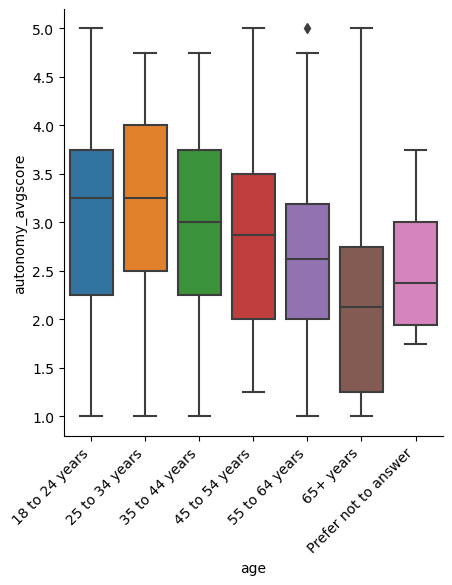

In [49]:
automony_age_boxplot = sns.catplot(data=df, x='age', y='autonomy_avgscore', kind='box', order=age_order_list)
automony_age_boxplot.set_xticklabels(rotation=45, ha='right')
plt.show()

In [ ]:
sns.displot(data=df, x='autonomy_avgscore', kde=True)

# RQ1
What extent does smartphone usage impact perceived psychological wellbeing?

## What is the overall perceived psychological wellbeing of the surveyed population?

### Relatedness

Mean relatedness score = 3.7951282051282047
Relatedness distribution skew = -1.1290978985799531
Relatedness kurtosis = 1.2863096341655638
Relatedness score count = 351


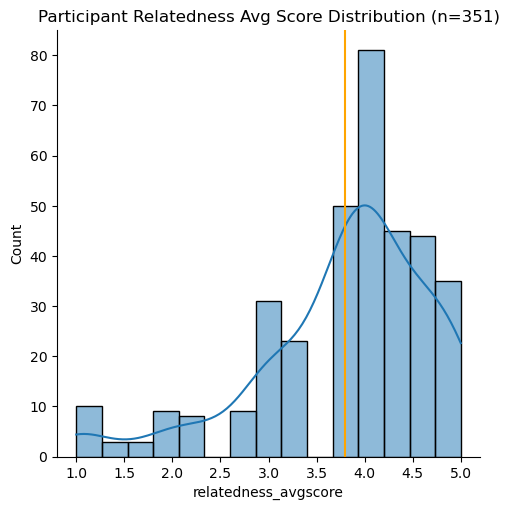

In [12]:
# Positive scoring. Higher the number the more feeling of relatedness
print('Mean relatedness score =', df['relatedness_avgscore'].mean())
print('Relatedness distribution skew =', df['relatedness_avgscore'].skew())
print('Relatedness kurtosis =', df['relatedness_avgscore'].kurt())
print('Relatedness score count =', df['relatedness_avgscore'].count())

sns.displot(data=df, x='relatedness_avgscore', kde=True)
plt.title('Participant Relatedness Avg Score Distribution (n=351)')
plt.axvline(df['relatedness_avgscore'].mean(), color='orange')

# The mean relatedness score for smartphone usage was 3.795 with a right-skew. This means that on average, people feel that their smartphone usage
# is somewhere between having no effect and somewhat of a postive influence on their overall perceived life relatedness with others.
# The right-skews means that most people feel that their smartphone usage has a positive influence on the satisfaction of their relatedness psychological need.

### Competence

Mean competence score = 1.9597134670487104
Competence distribution skew = 0.8681824443986293
Competence kurtosis = -0.32203755078077334
Competence score count = 349


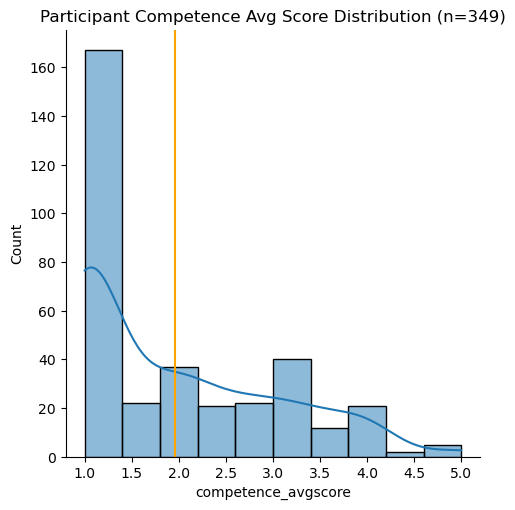

In [13]:
# Negative scoring. The lower the number the more feeling of competence
print('Mean competence score =', df['competence_avgscore'].mean())
print('Competence distribution skew =', df['competence_avgscore'].skew())
print('Competence kurtosis =', df['competence_avgscore'].kurt())
print('Competence score count =', df['competence_avgscore'].count())

sns.displot(data=df, x='competence_avgscore', kde=True)
plt.title('Participant Competence Avg Score Distribution (n=349)')
plt.axvline(df['competence_avgscore'].mean(), color='orange')

# The mean competence score for smartphone usage was 1.959 with a left-skew. This means that on average, people feel that their smartphone usage
# is somewhere between not affecting to slightly affecting their overall perceived life competence.
# The left-skew means that most people feel that their smartphone usage has no negative influence on the satisfaction of their competence psychological need.

### Autonomy

Mean autonomy score = 2.8956521739130436
Autonomy distribution skew = -0.11856326339261074
Autonomy kurtosis = -0.7899310505112349
Autonomy score count = 345


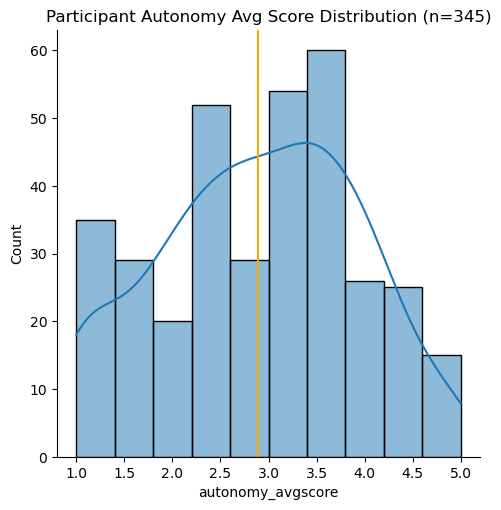

In [15]:
# Negative scoring. the lower the number the more feeling of autonomy
print('Mean autonomy score =', df['autonomy_avgscore'].mean())
print('Autonomy distribution skew =', df['autonomy_avgscore'].skew())
print('Autonomy kurtosis =', df['autonomy_avgscore'].kurt())
print('Autonomy score count =', df['autonomy_avgscore'].count())

sns.displot(data=df, x='autonomy_avgscore', kde=True)
plt.title('Participant Autonomy Avg Score Distribution (n=345)')
plt.axvline(df['autonomy_avgscore'].mean(), color='orange')

# The mean autonomy score for smartphone usage was 2.895 with a slilght right-skew. This means that on average, people feel that their smartphone usage
# is somewhere between not affecting to slightly affecting their overall perceived life autonomy.
# The right-skew means that most people feel that their smartphone usage has a slight negative influence on the satisfaction of their autonomy psychological need.

## What is the perceived psychological wellbeing by age?

In [18]:
# remove "Prefer not to answer" (pnta) responses from analysis
no_age_pnta_df = df[df['age_encoded'] > 0]

### Autonomy

In [46]:
print('Autonomy score count by age =', no_age_pnta_df.groupby('age_categorical')['autonomy_avgscore'].count(), '\n')
print('Mean autonomy score by age =', no_age_pnta_df.groupby('age_categorical')['autonomy_avgscore'].mean(), '\n')
print('Autonomy distribution skew by age =', no_age_pnta_df.groupby('age_categorical')['autonomy_avgscore'].skew(), '\n')
print('Autonomy kurtosis by age =', no_age_pnta_df.groupby('age_categorical')['autonomy_avgscore'].apply(pd.DataFrame.kurt))

Mean autonomy score by age = age_categorical
18 to 24 years          3.037671
25 to 34 years          3.121795
35 to 44 years          2.918367
45 to 54 years          2.882812
55 to 64 years          2.666667
65+ years               2.162500
Prefer not to answer         NaN
Name: autonomy_avgscore, dtype: float64 

Autonomy distribution skew by = age_categorical
18 to 24 years         -0.305836
25 to 34 years         -0.366604
35 to 44 years         -0.426736
45 to 54 years          0.302614
55 to 64 years          0.414438
65+ years               1.002748
Prefer not to answer         NaN
Name: autonomy_avgscore, dtype: float64 

Autonomy kurtosis by age = age_categorical
18 to 24 years         -0.285103
25 to 34 years         -0.689687
35 to 44 years         -0.737076
45 to 54 years         -0.535288
55 to 64 years         -0.229322
65+ years               0.800562
Prefer not to answer         NaN
Name: autonomy_avgscore, dtype: float64
Autonomy score count by age = age_categorical
1

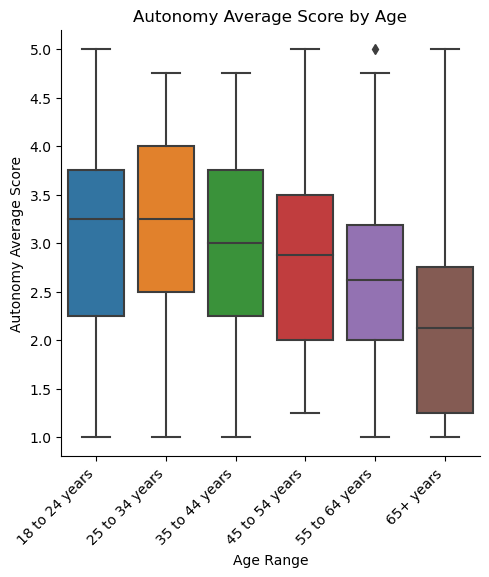

In [60]:
age_col_order = ['18 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years', '55 to 64 years', '65+ years']
autonomy_age_boxplot = sns.catplot(data=no_age_pnta_df, x='age', y='autonomy_avgscore', kind='box', order=age_col_order)
autonomy_age_boxplot.set(title='Autonomy Average Score by Age')
autonomy_age_boxplot.set_axis_labels(x_var='Age Range', y_var='Autonomy Average Score')
autonomy_age_boxplot.set_xticklabels(rotation=45, ha='right')

In [92]:
# Kruskal-Wallis H-test for independent samples on age group populations to see if there is a significant difference
# between the means of the population and that the false usage distribution mean is less than the true usage distribution mean

# Does not assume the same variances amongst the populations, but does require all groups to have at least 5 samples
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal

# Null hypothesis = The autonomy means are the same between age groups
# Alternative = The autonomy means are not the same between age groups
pivoted_no_age_pnta_df = pd.pivot_table(data=no_age_pnta_df, values=['autonomy_avgscore'], index=no_age_pnta_df.index, columns='age_categorical')['autonomy_avgscore']
a1 = pivoted_no_age_pnta_df['18 to 24 years']
a2 = pivoted_no_age_pnta_df['25 to 34 years']
a3 = pivoted_no_age_pnta_df['35 to 44 years']
a4 = pivoted_no_age_pnta_df['45 to 54 years']
a5 = pivoted_no_age_pnta_df['55 to 64 years']
a6 = pivoted_no_age_pnta_df['65+ years']

stats.kruskal( a1,a2,a3,a4,a5,a6, nan_policy='omit')

# Statistically significant, so we reject the null hypothesis. The autonomy means are not the same between age groups

KruskalResult(statistic=29.82112449888935, pvalue=1.5993659336180353e-05)

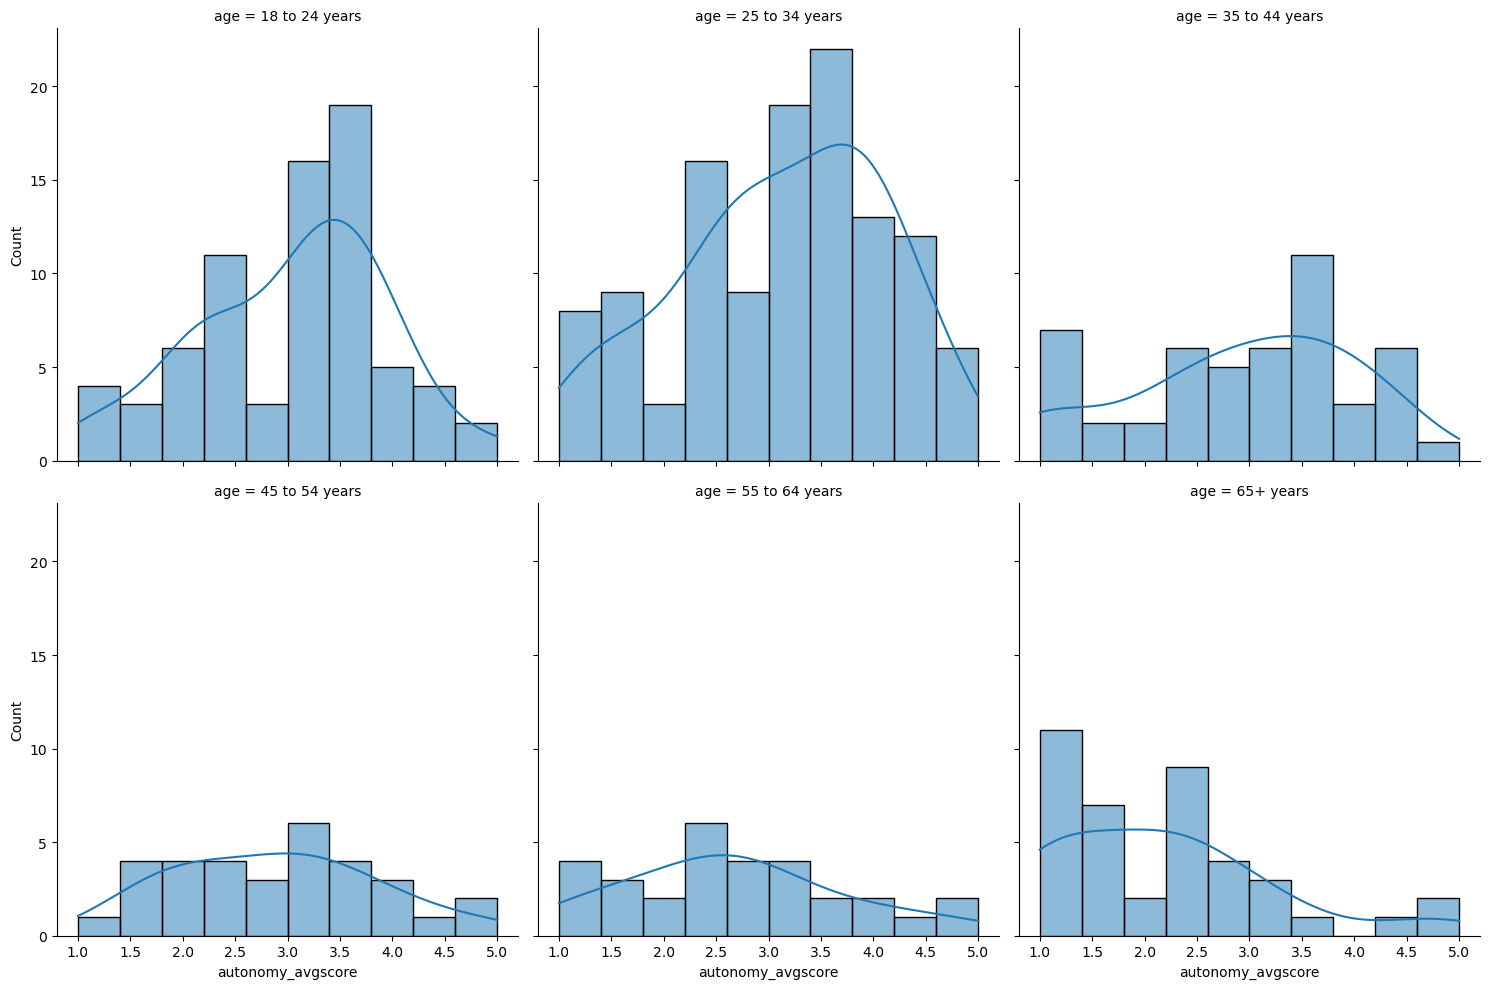

In [21]:
# Negative scoring. The lower the number the more feeling of autonomy
age_col_order = ['18 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years', '55 to 64 years', '65+ years']
autonomyplot = sns.displot(data=no_age_pnta_df, x='autonomy_avgscore', kde=True, col='age', col_order=age_col_order, col_wrap=3)

# 18 to 44 years old are leaning towards feeling less autonomous compared to the 45 to 65 years old populations

# rank-order correlation between age and autonomy to see the correlation

### Competence

In [47]:
print('Competence score count by age =', no_age_pnta_df.groupby('age_categorical')['autonomy_avgscore'].count())
print('Competence score mean by age =', no_age_pnta_df.groupby('age_categorical')['competence_avgscore'].mean(), '\n')
print('Competence distribution skew by age =', no_age_pnta_df.groupby('age_categorical')['competence_avgscore'].skew(), '\n')
print('Competence kurtosis by age =', no_age_pnta_df.groupby('age_categorical')['competence_avgscore'].apply(pd.DataFrame.kurt),'\n')

Competence score count by age = age_categorical
18 to 24 years           73
25 to 34 years          117
35 to 44 years           49
45 to 54 years           32
55 to 64 years           30
65+ years                40
Prefer not to answer      0
Name: autonomy_avgscore, dtype: int64
Competence score mean by age = age_categorical
18 to 24 years          2.378356
25 to 34 years          2.066207
35 to 44 years          1.781837
45 to 54 years          1.666562
55 to 64 years          1.744333
65+ years               1.637111
Prefer not to answer         NaN
Name: competence_avgscore, dtype: float64 

Competence distribution skew by age = age_categorical
18 to 24 years          0.134529
25 to 34 years          0.658836
35 to 44 years          1.490582
45 to 54 years          1.721309
55 to 64 years          1.727407
65+ years               1.246198
Prefer not to answer         NaN
Name: competence_avgscore, dtype: float64 

Competence kurtosis by age = age_categorical
18 to 24 years        

In [91]:
# Kruskal-Wallis H-test for independent samples on age group populations to see if there is a significant difference
# between the means of the population and that the false usage distribution mean is less than the true usage distribution mean

# Does not assume the same variances amongst the populations, but does require all groups to have at least 5 samples
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal

# Null hypothesis = The competence means are the same between age groups
# Alternative = The competence means are not the same between age groups
comp_pivoted_no_age_pnta_df = pd.pivot_table(data=no_age_pnta_df, values=['competence_avgscore'], index=no_age_pnta_df.index, columns='age_categorical')['competence_avgscore']
c1 = comp_pivoted_no_age_pnta_df['18 to 24 years']
c2 = comp_pivoted_no_age_pnta_df['25 to 34 years']
c3 = comp_pivoted_no_age_pnta_df['35 to 44 years']
c4 = comp_pivoted_no_age_pnta_df['45 to 54 years']
c5 = comp_pivoted_no_age_pnta_df['55 to 64 years']
c6 = comp_pivoted_no_age_pnta_df['65+ years']

stats.kruskal( c1,c2,c3,c4,c5,c6, nan_policy='omit')

# Statistically significant, so we reject the null hypothesis. The competence means are not the same between age groups

KruskalResult(statistic=26.71536263064471, pvalue=6.480310903912099e-05)

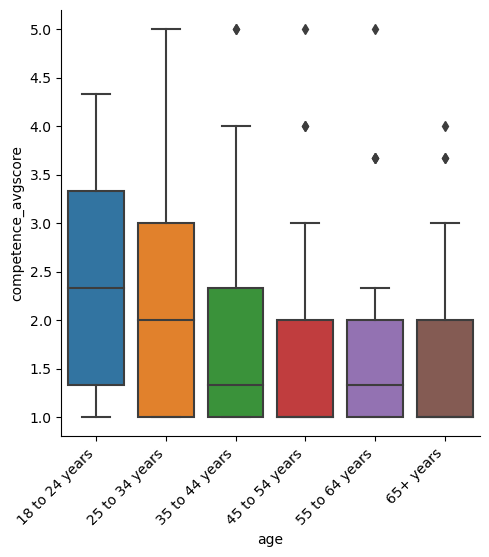

In [24]:
competence_age_boxplot = sns.catplot(data=no_age_pnta_df, x='age', y='competence_avgscore', kind='box', order=age_col_order)
competence_age_boxplot.set_xticklabels(rotation=45, ha='right')
plt.show()

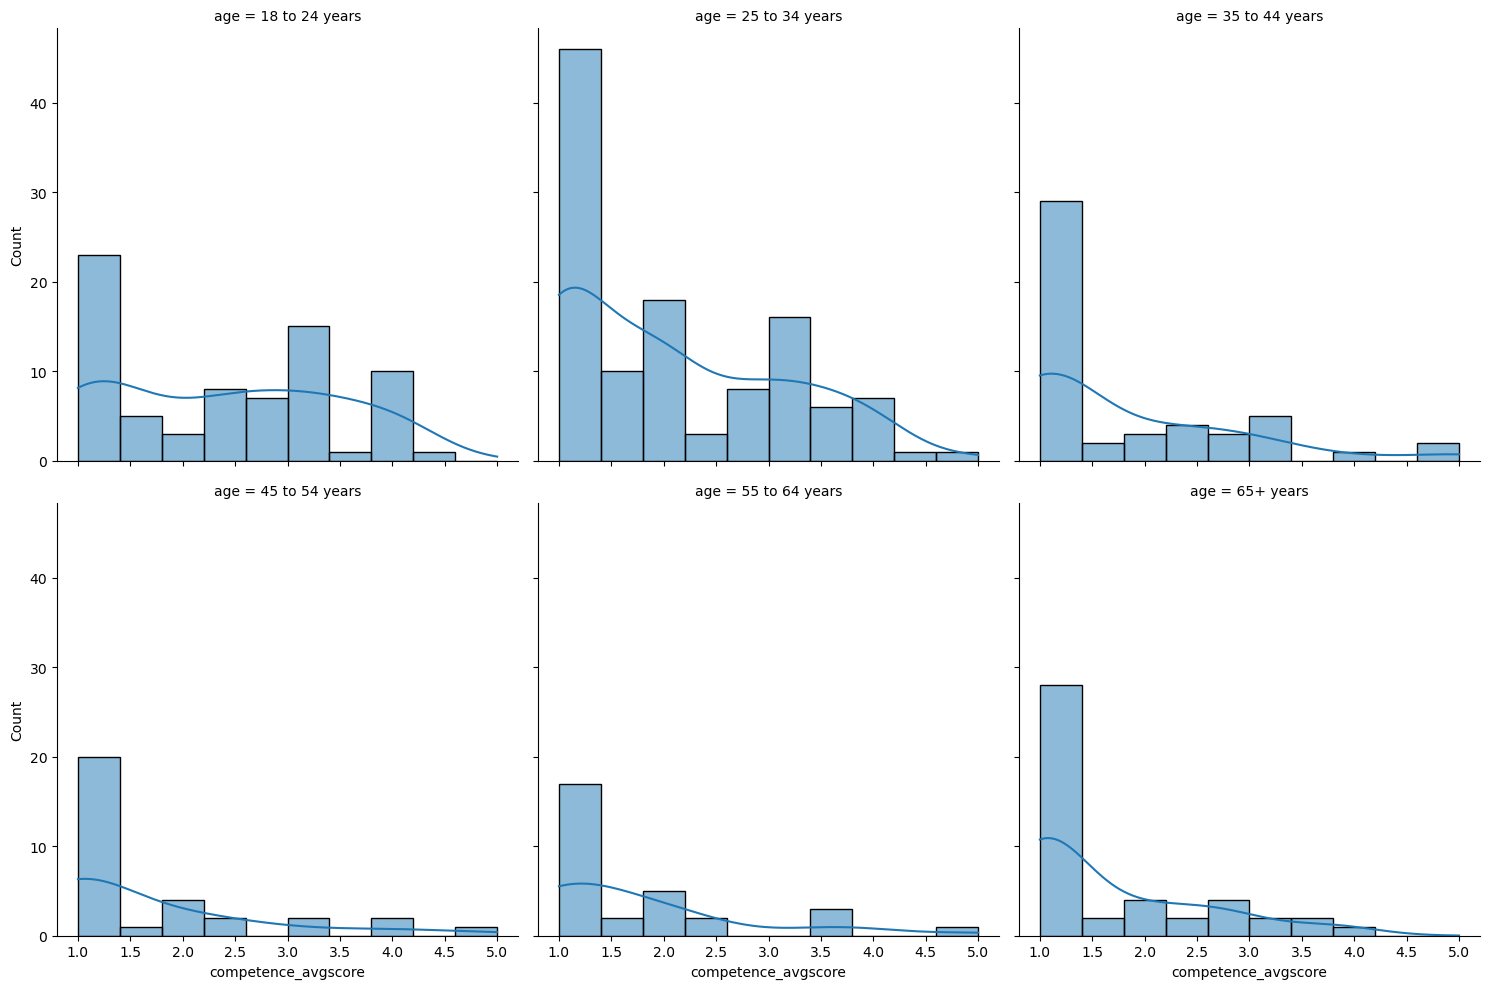

In [22]:
# Negative scoring. The lower the number the more feeling of competence
competenceplot = sns.displot(data=no_age_pnta_df, x='competence_avgscore', kde=True, col='age', col_order=age_col_order, col_wrap=3)
# 18 to 34 years old population mostly feels competent, but has more variation. 35+ populations consistenly non-negative impact competence

### Relatedness

In [48]:
print('Relatedness score count by age =', no_age_pnta_df.groupby('age_categorical')['relatedness_avgscore'].count())
print('Relatedness score mean by age =', no_age_pnta_df.groupby('age_categorical')['relatedness_avgscore'].mean(), '\n')
print('Relatedness distribution skew by age =', no_age_pnta_df.groupby('age_categorical')['relatedness_avgscore'].skew(), '\n')
print('Relatedness kurtosis by age =', no_age_pnta_df.groupby('age_categorical')['relatedness_avgscore'].apply(pd.DataFrame.kurt),'\n')

Relatedness score count by age = age_categorical
18 to 24 years           74
25 to 34 years          117
35 to 44 years           49
45 to 54 years           32
55 to 64 years           31
65+ years                44
Prefer not to answer      0
Name: relatedness_avgscore, dtype: int64
Relatedness score mean by age = age_categorical
18 to 24 years          4.013784
25 to 34 years          3.897436
35 to 44 years          3.503673
45 to 54 years          3.479062
55 to 64 years          3.914194
65+ years               3.743409
Prefer not to answer         NaN
Name: relatedness_avgscore, dtype: float64 

Relatedness distribution skew by age = age_categorical
18 to 24 years         -0.879199
25 to 34 years         -1.133003
35 to 44 years         -0.922515
45 to 54 years         -1.422843
55 to 64 years         -1.589233
65+ years              -1.093626
Prefer not to answer         NaN
Name: relatedness_avgscore, dtype: float64 

Relatedness kurtosis by age = age_categorical
18 to 24 year

In [93]:
# Kruskal-Wallis H-test for independent samples on age group populations to see if there is a significant difference
# between the means of the population and that the false usage distribution mean is less than the true usage distribution mean

# Does not assume the same variances amongst the populations, but does require all groups to have at least 5 samples
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal

# Null hypothesis = The competence means are the same between age groups
# Alternative = The competence means are not the same between age groups
rela_pivoted_no_age_pnta_df = pd.pivot_table(data=no_age_pnta_df, values=['relatedness_avgscore'], index=no_age_pnta_df.index, columns='age_categorical')['relatedness_avgscore']
r1 = rela_pivoted_no_age_pnta_df['18 to 24 years']
r2 = rela_pivoted_no_age_pnta_df['25 to 34 years']
r3 = rela_pivoted_no_age_pnta_df['35 to 44 years']
r4 = rela_pivoted_no_age_pnta_df['45 to 54 years']
r5 = rela_pivoted_no_age_pnta_df['55 to 64 years']
r6 = rela_pivoted_no_age_pnta_df['65+ years']

stats.kruskal( r1,r2,r3,r4,r5,r6, nan_policy='omit')

# Statistically significant, so we reject the null hypothesis. The autonomy means are not the same between age groups

KruskalResult(statistic=13.85386243769631, pvalue=0.016564838918618013)

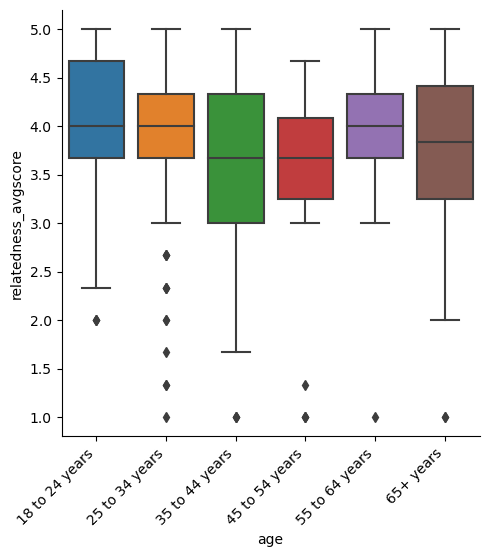

In [25]:
relatedness_age_boxplot = sns.catplot(data=no_age_pnta_df, x='age', y='relatedness_avgscore', kind='box', order=age_col_order)
relatedness_age_boxplot.set_xticklabels(rotation=45, ha='right')
plt.show()

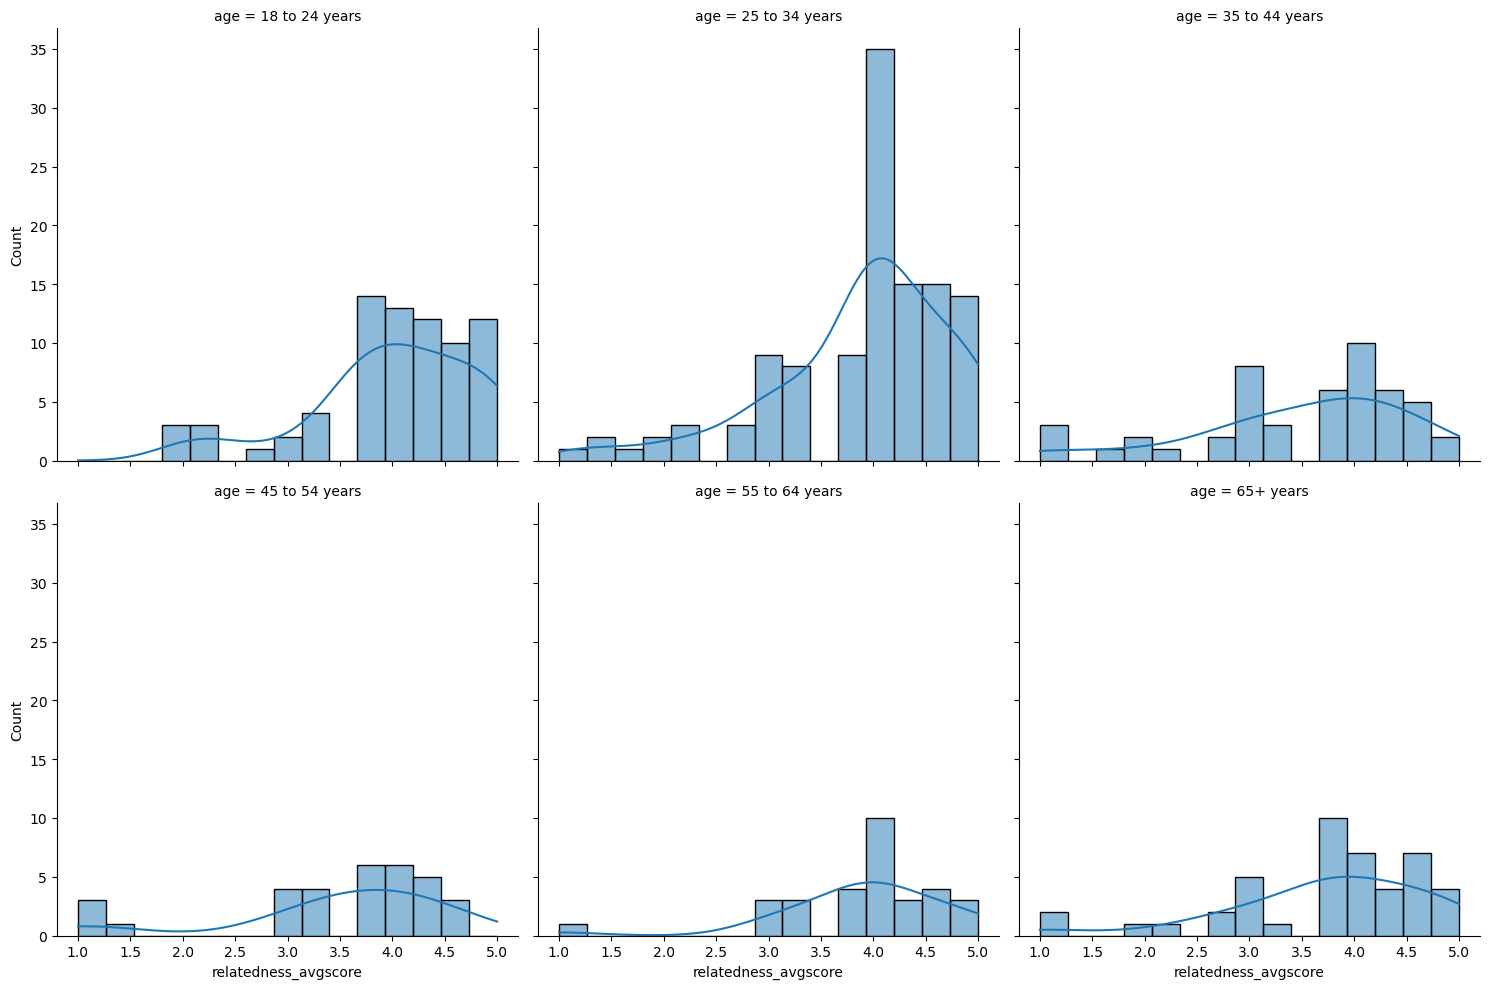

In [23]:
# Positive scoring. The higher the number the more feeling of relatedness
relatednessplot = sns.displot(data=no_age_pnta_df, x='relatedness_avgscore', kde=True, col='age', col_order=age_col_order, col_wrap=3)
# All age groups show higher relatedness scores meaning more overall life feelings of relatedess from smartphone usage

## What is the perceived psychological wellbeing of iPhone versus Android users?

### Autonomy

In [26]:
no_phone_pnta_df = df[df['iphone_flag'] >= 0]

In [53]:
print('Autonomy score count by age =', no_phone_pnta_df.groupby('iphone_flag')['autonomy_avgscore'].count(),'\n')
print('Autonomy score mean by age =', no_phone_pnta_df.groupby('iphone_flag')['autonomy_avgscore'].mean(), '\n')
print('Autonomy distribution skew by age =', no_phone_pnta_df.groupby('iphone_flag')['autonomy_avgscore'].skew(), '\n')
print('Autonomy kurtosis by age =', no_phone_pnta_df.groupby('iphone_flag')['autonomy_avgscore'].apply(pd.DataFrame.kurt),'\n')

Autonomy score count by age = iphone_flag
0    100
1    244
Name: autonomy_avgscore, dtype: int64 

Autonomy score mean by age = iphone_flag
0    2.870000
1    2.906762
Name: autonomy_avgscore, dtype: float64 

Autonomy distribution skew by age = iphone_flag
0   -0.059785
1   -0.145188
Name: autonomy_avgscore, dtype: float64 

Autonomy kurtosis by age = iphone_flag
0   -0.921942
1   -0.729555
Name: autonomy_avgscore, dtype: float64 



In [57]:
# Use Welch's T-test (which does not assume same variance) on usage flag populations to see if there is a significant difference
# between the means of the population and that the false usage distribution mean is less than the true usage distribution mean

# Null hypothesis = The autonomy means are the same for people who use iPhone and Android
# Alternative = The autonomy means are not the same for people who use iPhone and Android

iphone_auto_df = no_phone_pnta_df[no_phone_pnta_df['iphone_flag'] == 1]['autonomy_avgscore']
android_auto_df = no_phone_pnta_df[no_phone_pnta_df['iphone_flag'] == 0]['autonomy_avgscore']

stats.ttest_ind(  a=np.array(android_auto_df)
                , b=np.array(iphone_auto_df)
                , equal_var=False
                , nan_policy='omit'
                , alternative='two-sided') # If significant, this means that those who use iPhones, feel less autonomy than those who use Android

# Not statistically significant, so we do not reject the null hypothesis. iPhone and Android users means are the same for autonomy

Ttest_indResult(statistic=-0.29441393689213047, pvalue=0.7687861935952895)

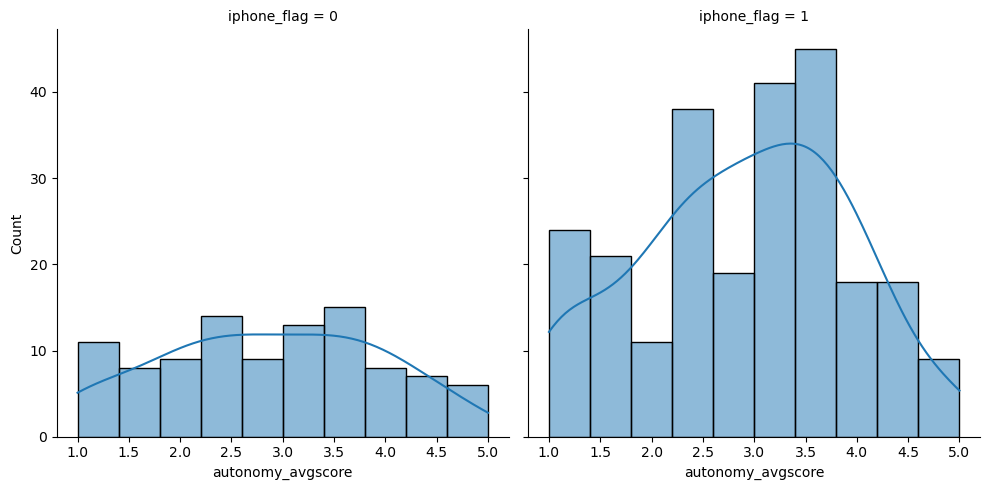

In [27]:
# Negative scoring. The lower the number the more feeling of autonomy
no_phone_pnta_df = df[df['iphone_flag'] >= 0]

sns.displot(data=no_phone_pnta_df, x='autonomy_avgscore', kde=True, col='iphone_flag')

# Android users (flag = 0), have a normally distributed shaped score of autonomy. iPhone users have a slight right-skew in the autonomy score.
# This means that more iPhone users feel that their smartphone usage has slightly negatively impacted their overall life feeling of autonomy.

### Competence

In [52]:
print('Competence score count by age =', no_phone_pnta_df.groupby('iphone_flag')['competence_avgscore'].count(),'\n')
print('Competence score mean by age =', no_phone_pnta_df.groupby('iphone_flag')['competence_avgscore'].mean(), '\n')
print('Competence distribution skew by age =', no_phone_pnta_df.groupby('iphone_flag')['competence_avgscore'].skew(), '\n')
print('Competence kurtosis by age =', no_phone_pnta_df.groupby('iphone_flag')['competence_avgscore'].apply(pd.DataFrame.kurt),'\n')

Competence score count by age = iphone_flag
0    103
1    245
Name: competence_avgscore, dtype: int64 

Competence score mean by age = iphone_flag
0    1.850777
1    2.009429
Name: competence_avgscore, dtype: float64 

Competence distribution skew by age = iphone_flag
0    0.975474
1    0.810386
Name: competence_avgscore, dtype: float64 

Competence kurtosis by age = iphone_flag
0    0.126551
1   -0.495096
Name: competence_avgscore, dtype: float64 



In [58]:
# Use Welch's T-test (which does not assume same variance) on usage flag populations to see if there is a significant difference
# between the means of the population and that the false usage distribution mean is less than the true usage distribution mean

# Null hypothesis = The competenece means are the same for people who use iPhone and Android
# Alternative = The competence means are not the same for people who use iPhone and Android

iphone_comp_df = no_phone_pnta_df[no_phone_pnta_df['iphone_flag'] == 1]['competence_avgscore']
android_comp_df = no_phone_pnta_df[no_phone_pnta_df['iphone_flag'] == 0]['competence_avgscore']

stats.ttest_ind(  a=np.array(android_comp_df)
                , b=np.array(iphone_comp_df)
                , equal_var=False
                , nan_policy='omit'
                , alternative='two-sided') # If significant, this means that those who use iPhones, feel less autonomy than those who use Android

# Not statistically significant, so we do not reject the null hypothesis. iPhone and Android users means are the same for competence

Ttest_indResult(statistic=-1.3402178323159004, pvalue=0.18158281347058566)

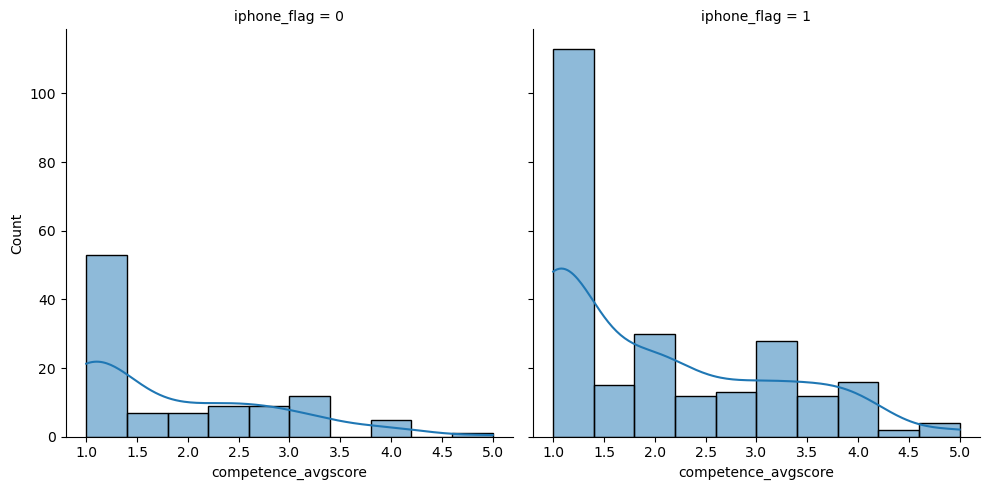

In [28]:
# Negative scoring. The lower the number the more feeling of competence
sns.displot(data=no_phone_pnta_df, x='competence_avgscore', kde=True, col='iphone_flag')
# Android and iPhone users feel that their smartphone usage has a non-negative impact to their overall feelings of competence.

### Relatedness

In [51]:
print('Relatedness score count by age =', no_phone_pnta_df.groupby('iphone_flag')['relatedness_avgscore'].count(),'\n')
print('Relatedness score mean by age =', no_phone_pnta_df.groupby('iphone_flag')['relatedness_avgscore'].mean(), '\n')
print('Relatedness distribution skew by age =', no_phone_pnta_df.groupby('iphone_flag')['relatedness_avgscore'].skew(), '\n')
print('Relatedness kurtosis by age =', no_phone_pnta_df.groupby('iphone_flag')['relatedness_avgscore'].apply(pd.DataFrame.kurt),'\n')

Relatedness score count by age = iphone_flag
0    104
1    246
Name: relatedness_avgscore, dtype: int64 

Relatedness score mean by age = iphone_flag
0    3.587019
1    3.880935
Name: relatedness_avgscore, dtype: float64 

Relatedness distribution skew by age = iphone_flag
0   -0.811949
1   -1.288355
Name: relatedness_avgscore, dtype: float64 

Relatedness kurtosis by age = iphone_flag
0    0.502392
1    1.899064
Name: relatedness_avgscore, dtype: float64 



In [59]:
# Use Welch's T-test (which does not assume same variance) on usage flag populations to see if there is a significant difference
# between the means of the population and that the false usage distribution mean is less than the true usage distribution mean

# Null hypothesis = The relatedness means are the same for people who use iPhone and Android
# Alternative = The relatedness means are not the same for people who use iPhone and Android

iphone_rela_df = no_phone_pnta_df[no_phone_pnta_df['iphone_flag'] == 1]['relatedness_avgscore']
android_rela_df = no_phone_pnta_df[no_phone_pnta_df['iphone_flag'] == 0]['relatedness_avgscore']

stats.ttest_ind(  a=np.array(android_rela_df)
                , b=np.array(iphone_rela_df)
                , equal_var=False
                , nan_policy='omit'
                , alternative='two-sided') # If significant, this means that those who use iPhones, feel less autonomy than those who use Android

# Statistically significant, so we reject the null hypothesis. iPhone and Android users means are not the same for relatedness

Ttest_indResult(statistic=-2.641156707881833, pvalue=0.009007951928690673)

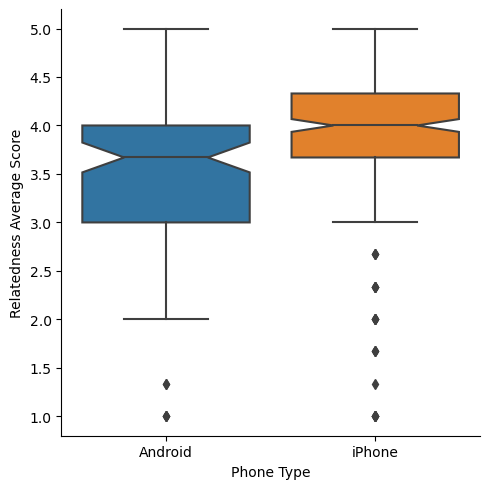

In [49]:
relatedness_phonetype_boxplot = sns.catplot(data=no_phone_pnta_df, x='iphone_flag', y='relatedness_avgscore', kind='box', notch=True)
relatedness_phonetype_boxplot.set_xticklabels(['Android', 'iPhone'])
relatedness_phonetype_boxplot.set_axis_labels(x_var='Phone Type', y_var='Relatedness Average Score')
plt.show()

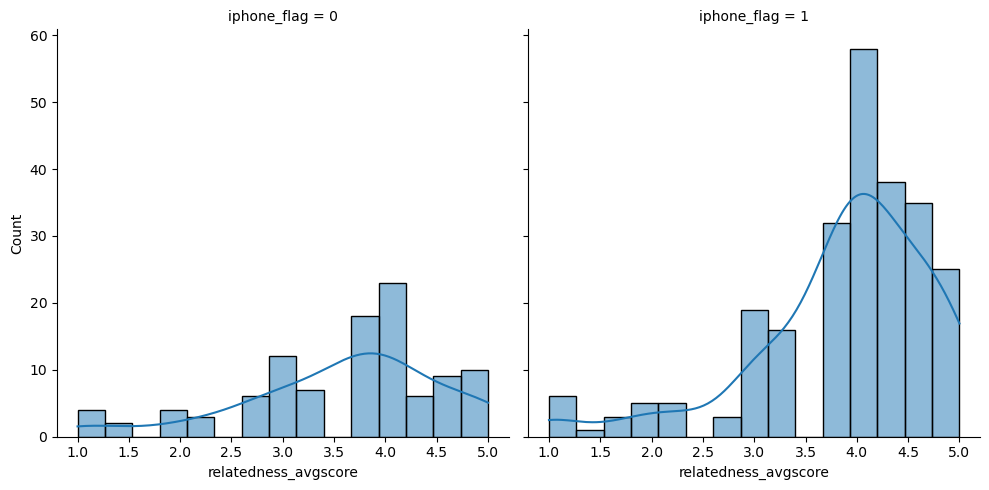

In [29]:
# Positive scoring. The higher the number the more feeling of relatedness
sns.displot(data=no_phone_pnta_df, x='relatedness_avgscore', kde=True, col='iphone_flag')
# Android and iPhone users feel that their smartphone usage has a positive impact to their overall feelings of relatedness.

# RQ2
How aware of and widely used are smartphone features aimed to support wellbeing?

## Does how one learns about smartphone features affect feature awareness and usage?
Hypothesis: Active learners of features are more likely to be aware of wellbeing features compared to passive leaners

## 

In [96]:
ct = pd.crosstab(df['active_learn_method_flag'], df['awareness_flag'])
ct
# passive/unaware, passive/aware
# active/unaware, active/aware

awareness_flag,0,1
active_learn_method_flag,,
0,45,223
1,4,81


In [97]:
# Null hypothesis - active learners and passive learners have the same probability in their awareness of wellbeing features
# Alternative hypothesis - active learners are more likey to be aware than passive learners of wellbeing features
# p-value of less than 0.05 for significance

# Not all values are at least 5 so we cannot use chi-square test

# Use Barnard exact https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.barnard_exact.html#scipy.stats.barnard_exact
ber = stats.barnard_exact(table=ct, alternative='greater')
print(ber)

# Reject null hypothesis, active learners are more likey to be aware than passive learners of wellbeing features

BarnardExactResult(statistic=2.8079015228830455, pvalue=0.010025422201176078)


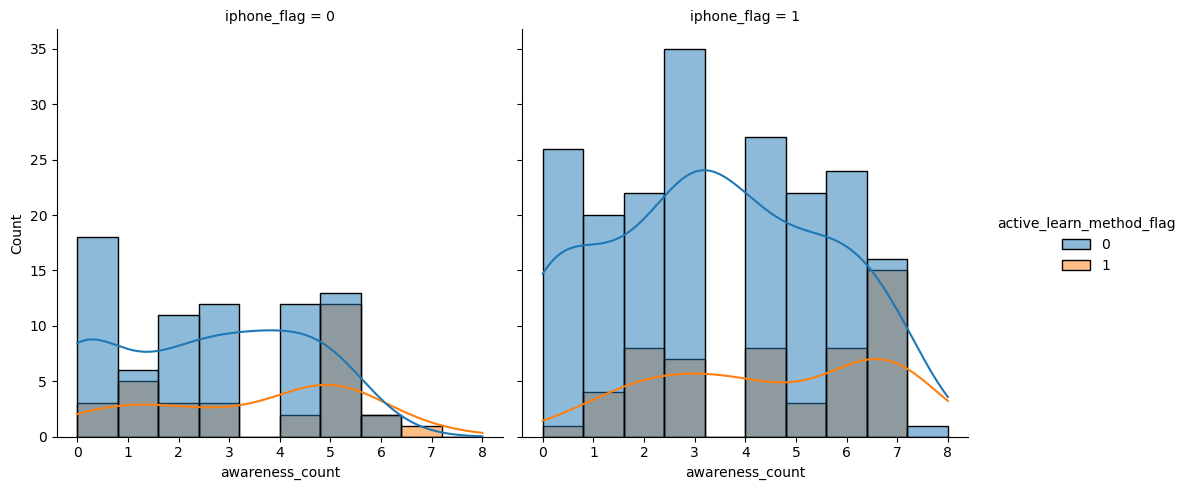

In [79]:
sns.displot(data=no_phone_pnta_df, x='awareness_count', hue='active_learn_method_flag', col='iphone_flag', kde=True)

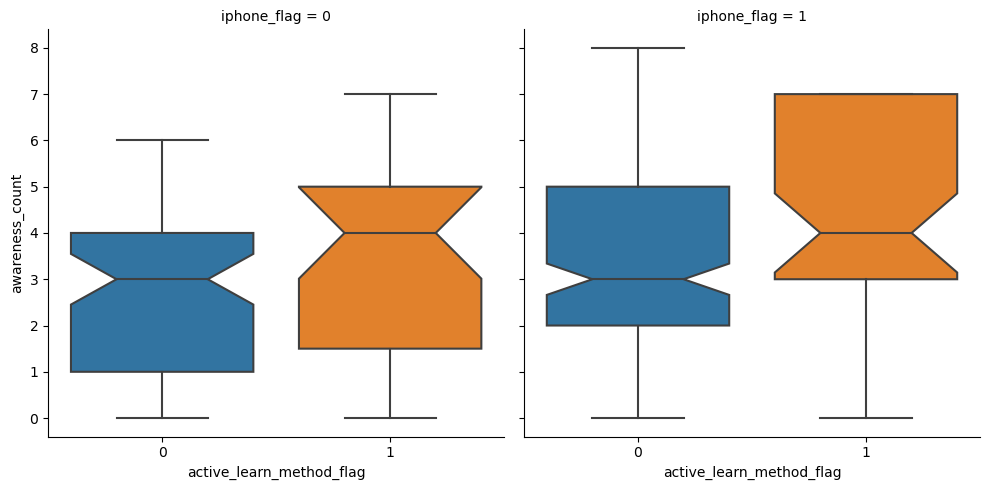

In [80]:
# Examine if active learners know about more features than passive learners
# Null hypothesis - The distribution awareness counts for active and passive learners are the same
# Alternative hypothesis - Active learners are aware of more features than passive learners
# p-value of less than 0.05 for significance

learn_method_boxplot = sns.catplot(data=no_phone_pnta_df, x='active_learn_method_flag', y='awareness_count', col='iphone_flag', kind='box', notch=True)
#relatedness_age_boxplot.set_xticklabels(rotation=45, ha='right')
#plt.show()

# use a statistic to demonstrate if the medians are significantly different

In [83]:
# Examine if active learners know about more features than passive learners
# Null hypothesis - The distribution awareness counts for active and passive learners are the same
# Alternative hypothesis - Active learners are aware of more features than passive learners
# p-value of less than 0.05 for significance

# Data not normally distributed so use Mann Whitney instead of T-Test
from scipy.stats import mannwhitneyu

iphone_user_df = df[df['iphone_flag'] == 1]
android_user_df = df[df['iphone_flag'] == 0]

iphone_passive_learn = iphone_user_df[iphone_user_df['active_learn_method_flag'] == 0]['awareness_count']
iphone_acitve_learn = iphone_user_df[iphone_user_df['active_learn_method_flag'] == 1]['awareness_count']
android_passive_learn = android_user_df[android_user_df['active_learn_method_flag'] == 0]['awareness_count']
android_active_learn = android_user_df[android_user_df['active_learn_method_flag'] == 1]['awareness_count']

# Since we hypothesize that passive learners are aware of less features than active learners, we choose alternative less
mannwhitney_iphone = mannwhitneyu(iphone_passive_learn, iphone_acitve_learn, alternative='less')
mannwhitney_android = mannwhitneyu(android_passive_learn, android_active_learn, alternative='less')

print('iPhone Mann Whitney=', mannwhitney_iphone)
print('Android Mann Whitney=', mannwhitney_android)

# statistically significant difference between active and passive learners for awareness count and that active learners are aware of more features

iPhone Mann Whitney= MannwhitneyuResult(statistic=3783.5, pvalue=0.0019275907865509017)
Android Mann Whitney= MannwhitneyuResult(statistic=838.5, pvalue=0.02800722897952329)


## Is wellbeing feature awareness related to usage?

In [95]:
awareness_usage_ct = pd.crosstab(df['awareness_flag'], df['usage_flag'])
awareness_usage_ct

# unaware/no usage, unaware/usage (this should be zero?)
# aware/no usage, aware/usage

usage_flag,0,1
awareness_flag,,
0,44,5
1,58,246


In [101]:
# Null hypothesis - Awareness of features and usage are not related
# Alternative hypothesis - Awareness of features and usage are related
# p-value of less than 0.05 for significance

# Use Chi-square test of independence
au_chi2 = stats.chi2_contingency(awareness_usage_ct)
print(f'Chi^2 statistic= {au_chi2[0]}, p-value= {au_chi2[1]}, degree of freedom = {au_chi2[2]}')

# Chi-square distribution table https://www.scribbr.com/statistics/chi-square-distribution-table/
# Right-tailed chi-square critical value for 1 df and 0.05 p-value is 3.841
# 99.298121 > 3.841
# We can reject the null hypothesis that awareness of features and usage are NOT related

Chi^2 statistic= 99.29812144571079, p-value= 2.172139951890496e-23, degree of freedom = 1


## Does the type of smartphone used affect awareness or usage of wellbeing features?

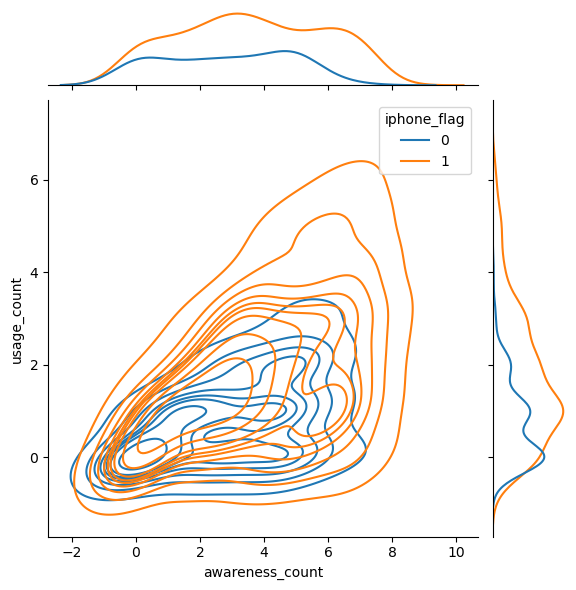

In [112]:
sns.jointplot(data=no_phone_pnta_df, x='awareness_count', y='usage_count', hue='iphone_flag', kind='kde')
# The awarenss of features is variable, but the usage of wellbeing is centralized to two or less for android and iphone
# The distribution of iphone awareness and usage is greater than android. So what? iPhone users

# RQ3

In [203]:
print(df[df['usage_flag'] == 0]['autonomy_avgscore'].shape)
print(df[df['usage_flag'] == 1]['autonomy_avgscore'].shape)

(102,)
(251,)


### Autonomy
Takeaway:
People who use wellbeing features on their smartphone do not have significantly less perceived feelings of autonomy towards their smartphone usage.
Put another way, usage of wellbeing features does not impact perceived feeling of smartphone usage autonomy significantly.

Wellbeing no usage mean autonomy score = 2.7551020408163267
Wellbeing usage mean autonomy score = 2.951417004048583


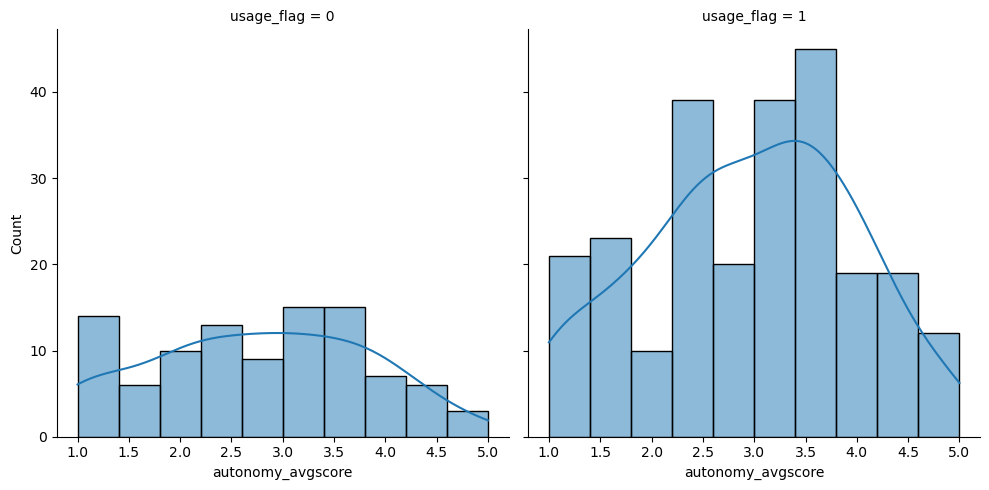

In [180]:
# Negative scoring. The lower the more feeling of autonomy
usage_false_autonomy_avg = df[df['usage_flag'] == 0]['autonomy_avgscore']
usage_true_autonomy_avg = df[df['usage_flag'] == 1]['autonomy_avgscore']

print('Wellbeing no usage mean autonomy score =', usage_false_autonomy_avg.mean())
print('Wellbeing usage mean autonomy score =', usage_true_autonomy_avg.mean())

sns.displot(data=df, x='autonomy_avgscore', col='usage_flag', kde=True)

In [237]:
# Check if variacnes are the same
print(np.var(usage_true_autonomy_avg))
print(np.var(usage_false_autonomy_avg))

1.030028356471996
1.0994637650978758


In [245]:
# Use Welch's T-test (which does not assume same variance) on usage flag populations to see if there is a significant difference
# between the means of the population and that the false usage distribution mean is less than the true usage distribution mean

# Null hypothesis = the means are the same for people who use and do not use wellbeing features
# Alternative = people who do not use wellbeing features have a mean greater than people who do use wellbeing features

stats.ttest_ind(  a=np.array(usage_true_autonomy_avg)
                , b=np.array(usage_false_autonomy_avg)
                , equal_var=False
                , nan_policy='omit'
                , alternative='greater') # If significant, this means that those who use wellbeing features, feel less autonomy than those who do NOT use wellbeing features

# Not statistically significant, so usage of wellbeing features and non-usage of wellbeing features have equal mean distributions

Ttest_indResult(statistic=1.5757327788727213, pvalue=0.05845919384668337)

### Competence
Takeaway:
Usage of wellbeing features does not impact perceived competence of smartphone usage

Wellbeing no usage mean competence score = 1.8365000000000002
Wellbeing usage mean competence score = 2.009196787148594


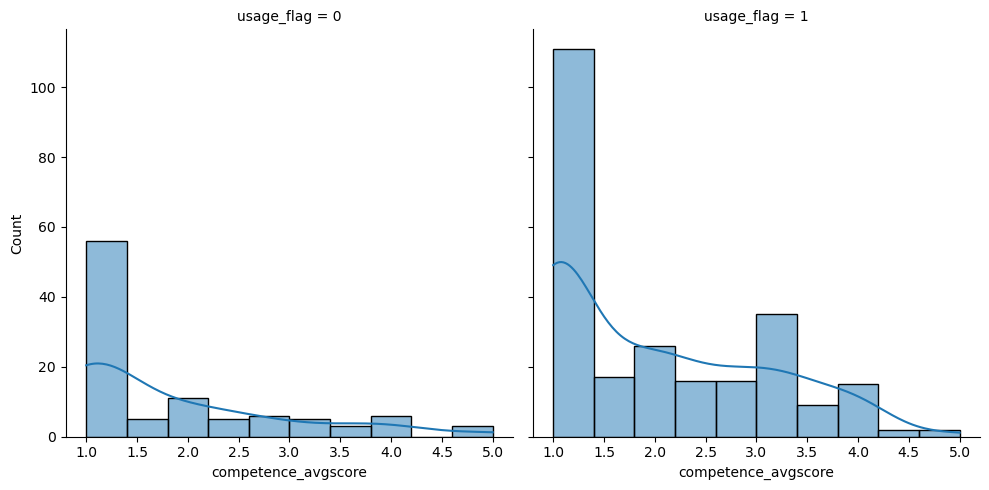

In [157]:
# Negative scoring. The lower the more feeling of competence
usage_false_competence_avg = df[df['usage_flag'] == 0]['competence_avgscore']
usage_true_competence_avg = df[df['usage_flag'] == 1]['competence_avgscore']

print('Wellbeing no usage mean competence score =', usage_false_competence_avg.mean())
print('Wellbeing usage mean competence score =', usage_true_competence_avg.mean())

sns.displot(data=df, x='competence_avgscore', col='usage_flag', kde=True)

In [239]:
# Chekc if variacnes are the same
print(np.var(usage_true_competence_avg))
print(np.var(usage_false_competence_avg))

1.1007318849695973
1.16400475


In [246]:
# Use Welch's T-test (which does not assume same variance) on usage flag populations to see if there is a significant difference
# between the means of the population and that the false usage distribution mean is less than the true usage distribution mean

stats.ttest_ind(  a=np.array(usage_true_competence_avg)
                , b=np.array(usage_false_competence_avg)
                , equal_var=False
                , nan_policy='omit'
                , alternative='greater') # If significant, this means that those who use wellbeing features feel less competence, than those who do NOT use wellbeing features

# Not statistically significant, so usage of wellbeing features and non-usage of wellbeing features have equal mean distributions for competence


Ttest_indResult(statistic=1.356999183018065, pvalue=0.08825113305318869)

### Relatedeness
Takeaway:
People who use wellbeing features have slightly increased perceived feelings of relatedness

Wellbeing no usage mean relatedness score = 3.6239000000000003
Wellbeing usage mean relatedness score = 3.8633466135458163


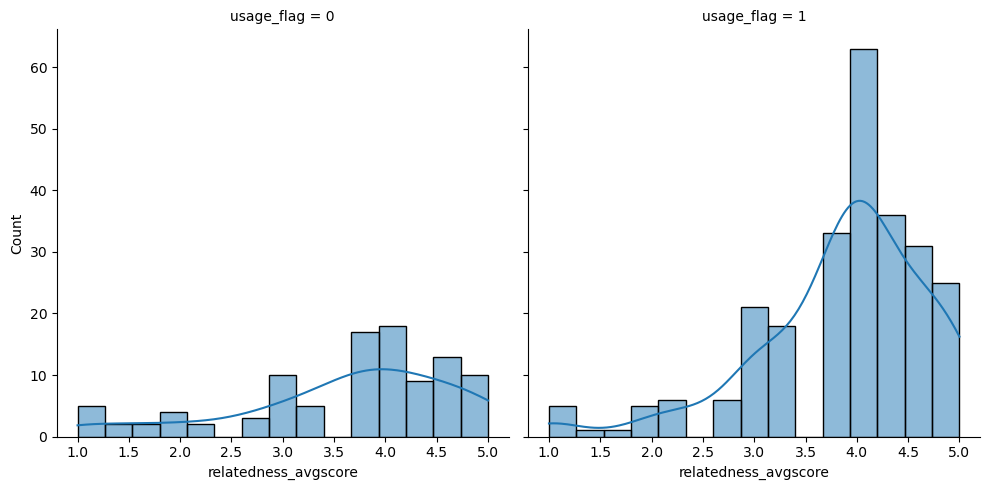

In [130]:
# Positive scoring. Higher the number the more feeling of relatedness
usage_false_relatedness_avg = df[df['usage_flag'] == 0]['relatedness_avgscore']
usage_true_relatedness_avg = df[df['usage_flag'] == 1]['relatedness_avgscore']

print('Wellbeing no usage mean relatedness score =', usage_false_relatedness_avg.mean())
print('Wellbeing usage mean relatedness score =', usage_true_relatedness_avg.mean())

sns.displot(data=df, x='relatedness_avgscore', col='usage_flag', kde=True)


In [241]:
# Check if variacnes are the same
print(np.var(usage_true_relatedness_avg))
print(np.var(usage_false_relatedness_avg))

0.7001099157156235
1.1376657900000002


In [247]:
# Use Welch's T-test (which does not assume same variance) on usage flag populations to see if there is a significant difference
# between the means of the population and that the false usage distribution mean is less than the true usage distribution mean

stats.ttest_ind(  a=np.array(usage_false_relatedness_avg)
                , b=np.array(usage_true_relatedness_avg)
                , equal_var=False
                , nan_policy='omit'
                , alternative='less') # If significant, this means that people who use wellbeing features feel more relatedness than those who do not use wellbeing features

# Statistically significant, so usage of wellbeing features has a relatedness mean greater than those who do not use wellbeing features
# Those who use wellbeing features on average, feel more relatedness than those who do not use wellbeing features


Ttest_indResult(statistic=-2.0029125760241686, pvalue=0.023496504925996982)

# RQ 4
What are the motivations behind the adoption of smartphone wellbeing features?

## Are motivations for smartphone wellbeing feature adoption motivated by extrinsic or intrinsic reasons?
Takeaway:
Adoption of wellbeing features is motivated by external identified regulation. This is moderately autonomous and in terms of user experience is because people think that using it will be worthwhile.

In [94]:
# Return the ACTA Score for people who used wellbeing features
acta_df = df[df['usage_flag'] == 1]

In [96]:
print('RAI score count =', acta_df['relative_autonomy_index'].count(),'\n')
print('RAI score median =', acta_df['relative_autonomy_index'].median(), '\n')
print('RAI score mean =', acta_df['relative_autonomy_index'].mean(), '\n')
print('RAI distribution skew =', acta_df['relative_autonomy_index'].skew(), '\n')
print('RAI kurtosis =', acta_df['relative_autonomy_index'].kurt(),'\n')

RAI score count = 249 

RAI score median = 1.5 

RAI score mean = 1.4642570281124496 

RAI distribution skew = -0.0424451621772112 

RAI kurtosis = -0.26076690767223454 



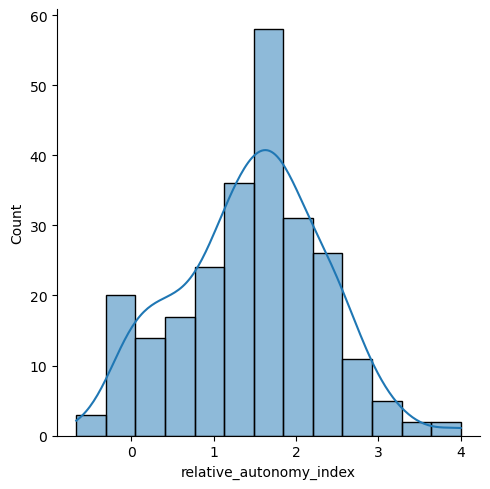

In [272]:
sns.displot(data=acta_df, x='relative_autonomy_index', kde=True)

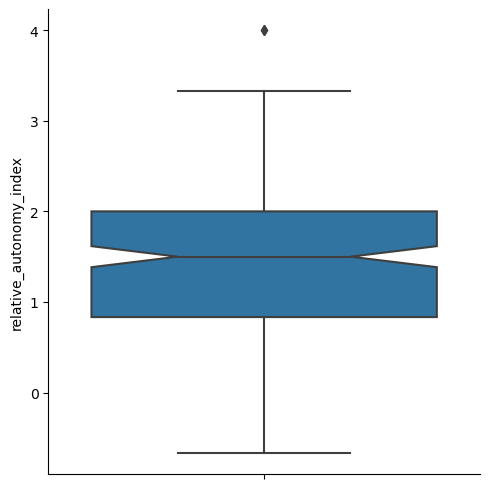

In [215]:
# The median is 1.5ish with majority within the 1-2 range.
# The max you can get is 4 which means completely intrinsinc
# Negative numbers mean the motivation is extrinsic which the extreme is -4
# From the METUX paper, zero would be somewhere between introjected and identified, so the 1.5 means that
# the motivations are more identified which is consistent with qualitative interviews
sns.catplot(data=acta_df, y='relative_autonomy_index', kind='box', notch=True)

# this is normally distributed

## Do motivations for adoption correlate with the TENS-Life scores of wellbeing?
There is not a significant relationship between feelings of autonomy and competence and adoption motivation. Therefore, people who feel more or less autonomy does about their smartphone usage does not affect their adoption. Same for competence.

There is a significant relationship between feeling of relatedness and adoption motivation. As the perceived relatedness increases, the motivation to adopt becomes more intrinsic. This suggests people who have higher feelings of relatedness due to their smartphone usage adopt wellbeing features for more autonomous reasons.

In [230]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr
# Data is ranked so we are using spearman-r which is able to test non-linear relationships

spearmanr_rai_autonomy = stats.spearmanr(acta_df['relative_autonomy_index'], acta_df['autonomy_avgscore'], nan_policy='omit')
spearmanr_rai_competence = stats.spearmanr(acta_df['relative_autonomy_index'], acta_df['competence_avgscore'], nan_policy='omit')
spearmanr_rai_relatedness = stats.spearmanr(acta_df['relative_autonomy_index'], acta_df['relatedness_avgscore'], nan_policy='omit')

# autonomy avg score, the less the value, the more feeling of autonomy
print('Spearman correlation test between RAI and autonomy: correlation =', spearmanr_rai_autonomy[0], '   p-value =', spearmanr_rai_autonomy[1] )
print('Spearman correlation test between RAI and competence: correlation =', spearmanr_rai_competence[0], '   p-value =', spearmanr_rai_competence[1] )
print('Spearman correlation test between RAI and relatedness: correlation =', spearmanr_rai_relatedness[0], '   p-value =', spearmanr_rai_relatedness[1] )

# The relationship between RAI and autonomy is a weak negative correlation and not statistically significant
# This negative realtionship means as motivation becomes more intrinsic, autonomy score decreases. This is negatively scored so lower score = autonomy feeling increases
# The negative relationship is expected as initrinsic motivations for adoption increase, I expected autonomy score to decrease since the scoring is reverse
# What is surprising is that there seems to be no statistically significant relationship between RAI and autonomy

# The relationship between RAI and competence is a weak negative correlation and not statistically significant
# Negative relationship means as motivation becomes more intrinsic competence score decreases. This is negatively scored so lower score = competence feeling increases
# 

# The realtionship between RAI and relateness is a weak positive correlation and statistically significant
# This positive relationship means as motivation becomes more intrinsic, relatedness score increases. This is positively scored so higher score = more feeling of relatedness
# 

Spearman correlation test between RAI and autonomy: correlation = -0.008622451785409983    p-value = 0.8931851160098905
Spearman correlation test between RAI and competence: correlation = -0.034400863698959665    p-value = 0.5905295363888966
Spearman correlation test between RAI and relatedness: correlation = 0.1288173456135114    p-value = 0.04226059825790443


In [234]:
# Kendall Tau also handles ordinal data and correlation tests
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html#scipy.stats.kendalltau

kendalltau_rai_autonomy = stats.kendalltau(acta_df['relative_autonomy_index'], acta_df['autonomy_avgscore'], nan_policy='omit')
kendalltau_rai_competence = stats.kendalltau(acta_df['relative_autonomy_index'], acta_df['competence_avgscore'], nan_policy='omit')
kendalltau_rai_relatedness = stats.kendalltau(acta_df['relative_autonomy_index'], acta_df['relatedness_avgscore'], nan_policy='omit')

# autonomy avg score, the less the value, the more feeling of autonomy
print('Kendall Tau correlation test between RAI and autonomy: correlation =', kendalltau_rai_autonomy[0], '   p-value =', kendalltau_rai_autonomy[1] )
print('Kendall Tau correlation test between RAI and competence: correlation =', kendalltau_rai_competence[0], '   p-value =', kendalltau_rai_competence[1] )
print('Kendall Tau correlation test between RAI and relatedness: correlation =', kendalltau_rai_relatedness[0], '   p-value =', kendalltau_rai_relatedness[1] )

# The results are similar to the spearman-r test

Kendall Tau correlation test between RAI and autonomy: correlation = -0.005306631858161527    p-value = 0.9059032413483424
Kendall Tau correlation test between RAI and competence: correlation = -0.020894257338091263    p-value = 0.6527299290777036
Kendall Tau correlation test between RAI and relatedness: correlation = 0.09650126364640946    p-value = 0.03530426289969298


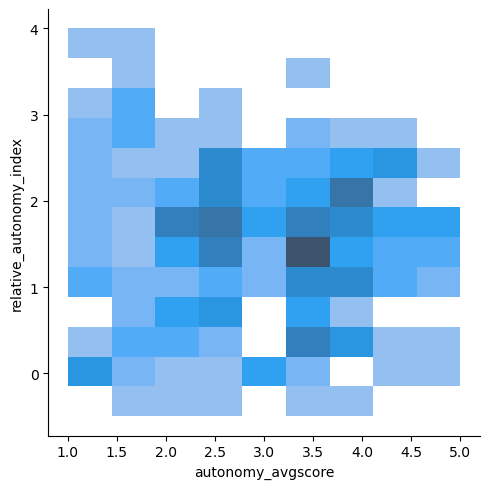

In [262]:
sns.displot(data=acta_df, x='autonomy_avgscore', y='relative_autonomy_index')

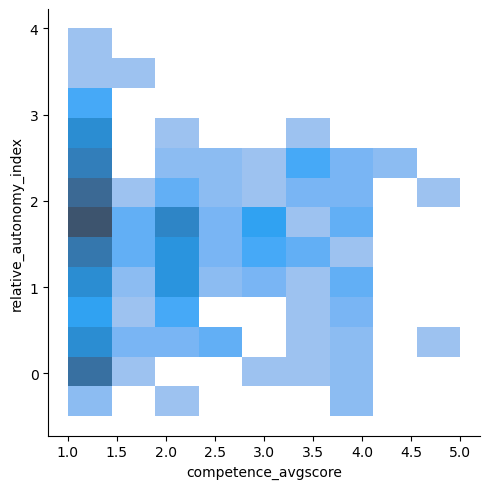

In [261]:
sns.displot(data=acta_df, x='competence_avgscore', y='relative_autonomy_index')

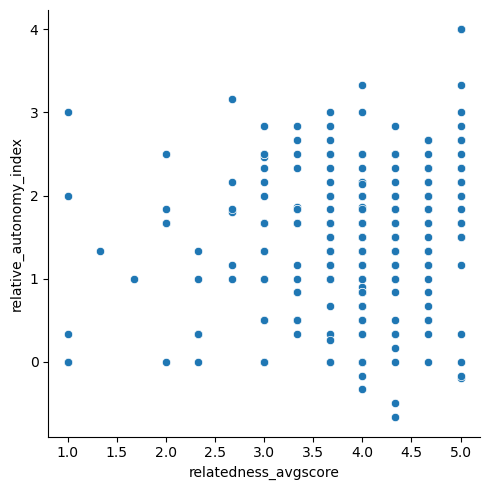

In [271]:
sns.relplot(data=acta_df, x='relatedness_avgscore', y='relative_autonomy_index')

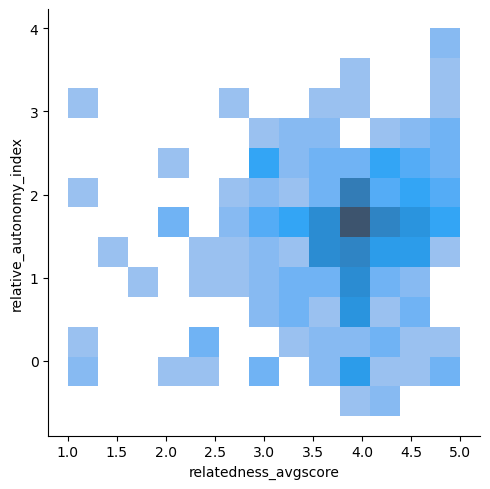

In [263]:
sns.displot(data=acta_df, x='relatedness_avgscore', y='relative_autonomy_index')

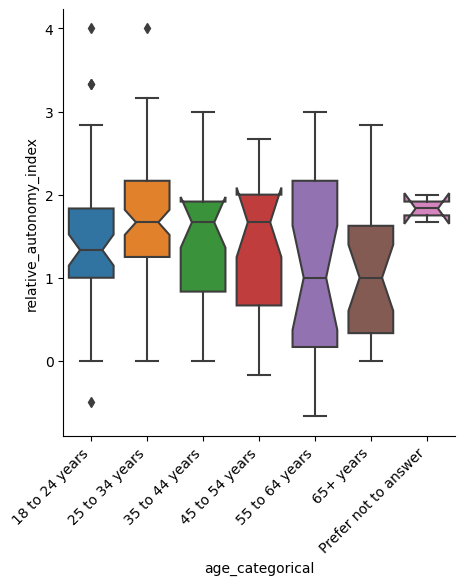

In [250]:
rai_age_boxplot = sns.catplot(data=acta_df, x='age_categorical', y='relative_autonomy_index', kind='box', notch=True)
rai_age_boxplot.set_xticklabels(rotation=45, ha='right')

# 25 to 54 year old wellbeing feature usage is more intrinsically motivated than 18 to 24 and 55+ age population
# Only 45 to 64 years old have distributions that are negative meaning slightly more extrinsic than intrinsic motivations
# There is staistical significance between 18 to 24 year old motivations and 25 to 34 year old motivations

# ANOVA between age and relative autonomy -> if significance there's a significance somewhere
# post-hoc test TUKEY -> test against all pairs of age groups

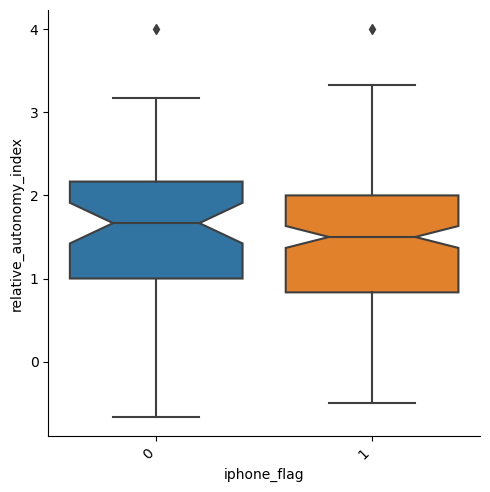

In [252]:
rai_phone_boxplot = sns.catplot(data=acta_df, x='iphone_flag', y='relative_autonomy_index', kind='box', notch=True)
rai_phone_boxplot.set_xticklabels(rotation=45, ha='right')

# phone type does not have any statistically significant information regarding motivation behind wellbeing feature adoption

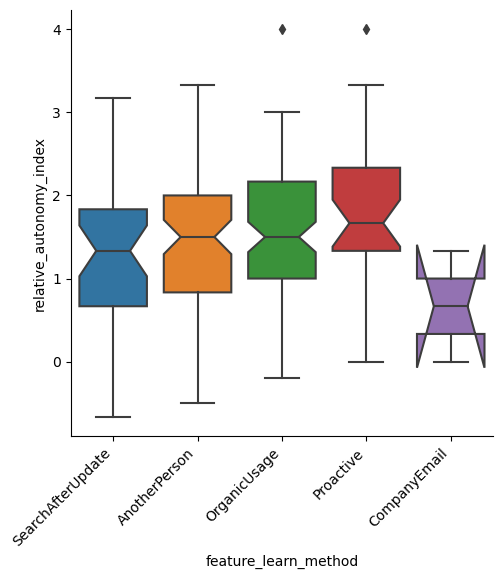

In [255]:
rai_flm_boxplot = sns.catplot(data=acta_df, x='feature_learn_method', y='relative_autonomy_index', kind='box', notch=True)
rai_flm_boxplot.set_xticklabels(rotation=45, ha='right')

# how people learn about features does not have a statistically significant difference in motivations for adoption of wellbeing features